In [1]:
from diffusers import LCMScheduler
class TimestepShiftLCMScheduler(LCMScheduler):
    def __init__(self, *args, shifted_timestep=250, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_to_config(shifted_timestep=shifted_timestep)
    def set_timesteps(self, *args, **kwargs):
        super().set_timesteps(*args, **kwargs)
        self.origin_timesteps = self.timesteps.clone()
        self.shifted_timesteps = (self.timesteps * self.config.shifted_timestep / self.config.num_train_timesteps).long()
        self.timesteps = self.shifted_timesteps
    def step(self, model_output, timestep, sample, generator=None, return_dict=True):
        if self.step_index is None:
            self._init_step_index(timestep)
        self.timesteps = self.origin_timesteps
        output = super().step(model_output, timestep, sample, generator, return_dict)
        self.timesteps = self.shifted_timesteps
        return output


In [2]:
import torch
from diffusers import DiffusionPipeline, UNet2DConditionModel
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file
import matplotlib.pyplot as plt

# Load model.
base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
repo = "ChenDY/NitroFusion"
# NitroSD-Realism
ckpt = "nitrosd-realism_unet.safetensors"
unet = UNet2DConditionModel.from_config(base_model_id, subfolder="unet").to("cuda", torch.float16)
unet.load_state_dict(load_file(hf_hub_download(repo, ckpt), device="cuda"))
scheduler = TimestepShiftLCMScheduler.from_pretrained(base_model_id, subfolder="scheduler", shifted_timestep=250)
scheduler.config.original_inference_steps = 4
# # NitroSD-Vibrant
# ckpt = "nitrosd-vibrant_unet.safetensors"
# unet = UNet2DConditionModel.from_config(base_model_id, subfolder="unet").to("cuda", torch.float16)
# unet.load_state_dict(load_file(hf_hub_download(repo, ckpt), device="cuda"))
# scheduler = TimestepShiftLCMScheduler.from_pretrained(base_model_id, subfolder="scheduler", shifted_timestep=500)
# scheduler.config.original_inference_steps = 4
pipe = DiffusionPipeline.from_pretrained(
    base_model_id,
    unet=unet,
    scheduler=scheduler,
    torch_dtype=torch.float16,
    variant="fp16",
).to("cuda")


C:\Users\mikec\anaconda3\Lib\site-packages\diffusers\configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
The config attributes {'clip_sample': False, 'sample_max_value': 1.0, 'set_alpha_to_one': False, 'skip_prk_steps': True} were passed to TimestepShiftLCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

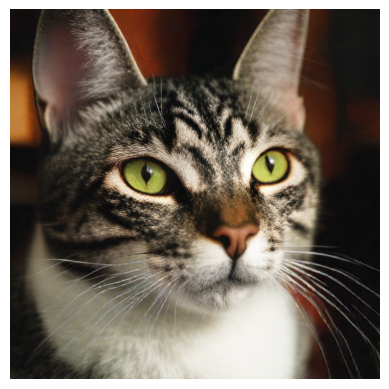

In [3]:
prompt = "a photo of a cat"
image = pipe(
    prompt=prompt,
    num_inference_steps=1,  # NotroSD-Realism and -Vibrant both support 1 - 4 inference steps.
    guidance_scale=0,
).images[0]

plt.imshow(image)
plt.axis('off')
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

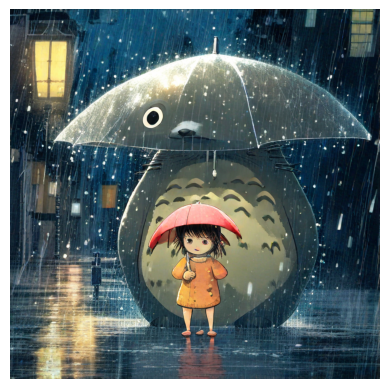

In [4]:
prompt = "An illustration of Totoro hold an umbrella with the little girl human in a raining night"
image = pipe(
    prompt=prompt,
    num_inference_steps=1,  # NotroSD-Realism and -Vibrant both support 1 - 4 inference steps.
    guidance_scale=0,
).images[0]

plt.imshow(image)
plt.axis('off')
plt.show()